# 1. Environment Setup
Installs the necessary Python libraries required to build the entire pipeline:
* **PyMuPDF (fitz):** For parsing and extracting raw text from PDF files.
* **SpaCy:** An industrial-strength NLP library used for identifying entities (like names and dates) and extracting grammatical relationships (triples).
* **Neo4j:** The official driver that allows Python to connect to and manipulate your Neo4j AuraDB graph database.
* **Sentence-Transformers:** Used to convert text chunks into numerical vectors (embeddings) for semantic search.
* **Google GenAI:** The SDK for accessing Google's Gemini models (specifically Gemini 2.0 Flash).
* **Streamlit & Pyngrok:** Frameworks for building the web user interface and creating a secure tunnel to host it from Colab.
* **Datasets & Scikit-Learn:** Used to load the HaluEval benchmark dataset and calculate performance metrics like F1-Score and Precision.



In [1]:
# Install dependencies
!pip install -q PyMuPDF spacy neo4j sentence-transformers networkx matplotlib langchain langchain-community langchain-text-splitters google-generativeai streamlit pyngrok datasets scikit-learn

# Download English language model for SpaCy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 117.3 MB/s eta 0:00:00
✔ Download and instal

# 2. Imports, Auth, & Model Initialization
This cell configures the API connections and loads the AI models into memory.
* **LLM:** Gemini 2.5 Flash (Chosen for its high speed and massive context window).
* **Embeddings:** `all-MiniLM-L6-v2` (An efficient model that creates 384-dimensional vectors).
* **Database:** Establishes a secure connection to your Neo4j Aura instance.
* **Libraries:** Loads visualization (`matplotlib`, `networkx`) and data handling (`pandas`) libraries.


In [17]:
import fitz  # PyMuPDF
import spacy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from neo4j import GraphDatabase
from google.colab import files
from langchain_text_splitters import RecursiveCharacterTextSplitter
import google.generativeai as genai
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import re
import difflib

# Import login function
from huggingface_hub import login

# ==========================================
# PASTE YOUR KEYS HERE
# ==========================================
HF_TOKEN = "Paste your hugging face key here"
GOOGLE_API_KEY = "Paste your gemini api key here"
NEO4J_URI = "Paste  your neo4j URI"
NEO4J_PASSWORD = "paste your password here"
NGROK_TOKEN = "paste your ngork token here"
# ==========================================

# 0. Authenticate with Hugging Face
if HF_TOKEN and not HF_TOKEN.startswith("PASTE"):
    try:
        login(token=HF_TOKEN)
        print("Logged in to Hugging Face!")
    except Exception as e:
        print(f" HF Login Failed: {e}")
else:
    print("Please paste a valid Hugging Face token above.")

# 1. Setup Gemini
if GOOGLE_API_KEY.startswith("PASTE"):
    print("Please enter your Google API Key above.")
else:
    genai.configure(api_key=GOOGLE_API_KEY)
    try:
        gemini_model = genai.GenerativeModel('models/gemini-2.5-flash')
        print("Gemini 2.5 Flash Loaded!")
    except Exception as e:
        print(f"Error loading Gemini: {e}")

# 2. Setup Embeddings & NLP
print("Loading Embedding Model & SpaCy...")
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
nlp = spacy.load("en_core_web_sm")
print("NLP Models Loaded!")

# 3. Connect to Graph DB
if NEO4J_PASSWORD.startswith("PASTE"):
    print("Please enter your Neo4j Password above.")
else:
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=("neo4j", NEO4J_PASSWORD))
        driver.verify_connectivity()
        print("Connected to Neo4j!")
    except Exception as e:
        print(f"Neo4j Connection Failed: {e}")

Logged in to Hugging Face!
Gemini 2.5 Flash Loaded!
Loading Embedding Model & SpaCy...
NLP Models Loaded!
Connected to Neo4j!


# 3. PDF Ingestion & Text Chunking
Handles the upload and preprocessing of the source document.
* **Text Extraction:** Uses PyMuPDF to scrape all text content from the uploaded PDF.
* **Chunking:** Splits the massive text string into smaller, manageable segments (1000 characters with 200 overlap).
* **RecursiveCharacterTextSplitter:** A smart tool that tries to break text at logical points (like paragraphs or sentences) rather than mid-word.



In [4]:
# Upload the PDF file
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

def extract_text_from_pdf(path):
    """Extracts raw text from the uploaded PDF."""
    text = ""
    with fitz.open(path) as doc:
        for page in doc: text += page.get_text("text") + "\n"
    return text

def create_chunks(text, chunk_size=1000, overlap=200):
    """Splits text into overlapping chunks for retrieval."""
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    return splitter.split_text(text)

# Process the PDF
pdf_text = extract_text_from_pdf(pdf_path)
chunks = create_chunks(pdf_text)
print(f"Processed {len(chunks)} chunks from {pdf_path}")

Saving demo-file.pdf to demo-file.pdf
Processed 72 chunks from demo-file.pdf


# 4. Advanced NLP Extraction (Triple Generation)
Uses SpaCy dependency parsing to turn unstructured text into structured facts.
* **Entity Extraction:** Identifies proper nouns (People, Organizations, Concepts).
* **Relation Extraction:** Finds `Subject -> Verb -> Object` patterns in sentences.
* **Knowledge Graph Structure:** These triples form the "nodes" and "edges" of our graph.



In [5]:
def extract_structured_data(text_chunk):
    """
    Uses SpaCy to extract Entities and S-V-O triples.
    Returns: list of entities, list of (Subject, Verb, Object) tuples
    """
    doc = nlp(text_chunk)
    # Extract Entities (excluding numbers like "1", "2023")
    entities = list({ent.text.strip() for ent in doc.ents if ent.label_ not in ["CARDINAL", "ORDINAL"]})
    triples = []

    for token in doc:
        # Find verbs that act as connectors
        if token.pos_ == "VERB":
            subj = ""
            obj = ""
            # Look for subjects and objects in the dependency tree
            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"): subj = child.text
                if child.dep_ in ("dobj", "attr", "pobj"): obj = child.text

            if subj and obj:
                # Clean up the verb (lemma) for the relationship type
                triples.append((subj, token.lemma_.upper(), obj))

    return entities, triples

# 5. Graph Database Ingestion
Populates the Neo4j database with our hybrid data structure.
* **Database Cleaning:** Wipes any existing data to ensure a fresh start.
* **Vector Index:** Creates a `chunkVectorIndex` to enable similarity search on text vectors.
* **Hybrid Storage:** Stores both the text chunks (for RAG) and the extracted entities (for the Graph) and links them together.


In [6]:
def ingest_chunks_to_neo4j(driver, doc_name, text_chunks):
    """
    1. Wipes database
    2. Creates Vector Index
    3. Ingests Chunks (Vector) and Entities (Graph)
    """
    with driver.session() as session:
        # 1. Clean DB
        session.run("MATCH (n) DETACH DELETE n")

        # 2. Create Vector Index
        try:
            session.run("DROP INDEX chunkVectorIndex IF EXISTS")
            session.run("""
                CREATE VECTOR INDEX chunkVectorIndex IF NOT EXISTS
                FOR (c:Chunk) ON (c.embedding)
                OPTIONS {indexConfig: { `vector.dimensions`: 384, `vector.similarity_function`: 'cosine' }}
            """)
            print("Vector Index Created.")
        except Exception as e:
            print(f"Index creation note: {e}")

        # 3. Ingest Data
        session.run("MERGE (d:Document {name: $name})", name=doc_name)
        print(f"Ingesting {len(text_chunks)} chunks...")

        for i, chunk in enumerate(text_chunks):
            emb = embedder.encode(chunk).tolist()
            ents, trips = extract_structured_data(chunk)

            # Create Chunk Node
            session.run("""
                MATCH (d:Document {name: $doc})
                MERGE (c:Chunk {chunkId: $i})
                SET c.text = $txt, c.embedding = $emb
                MERGE (d)-[:CONTAINS]->(c)
            """, doc=doc_name, i=i, txt=chunk, emb=emb)

            # Create Entity Relationships (The Knowledge Graph)
            for s, v, o in trips:
                 # Sanitize verb for relationship type (replace spaces/dashes with underscores)
                 v_clean = v.strip().upper().replace(" ", "_").replace("-", "_")
                 # Only create if verb is valid alphanumeric
                 if v_clean.replace("_", "").isalnum():
                     session.run(f"""
                        MERGE (a:Entity {{name: $s}})
                        MERGE (b:Entity {{name: $o}})
                        MERGE (a)-[:{v_clean}]->(b)
                     """, s=s, o=o)

# Run Ingestion
ingest_chunks_to_neo4j(driver, pdf_path, chunks)
print("Ingestion Complete!")

Vector Index Created.
Ingesting 72 chunks...
Ingestion Complete!


# 6. Graph Visualization (Knowledge Graph View)
Queries the database to generate a visual map of the extracted knowledge.
* **Cypher Query:** Fetches nodes and relationships from Neo4j.
* **NetworkX:** Builds a graph object in Python memory.
* **Matplotlib:** Draws the graph with nodes (Concepts) and edges (Actions).



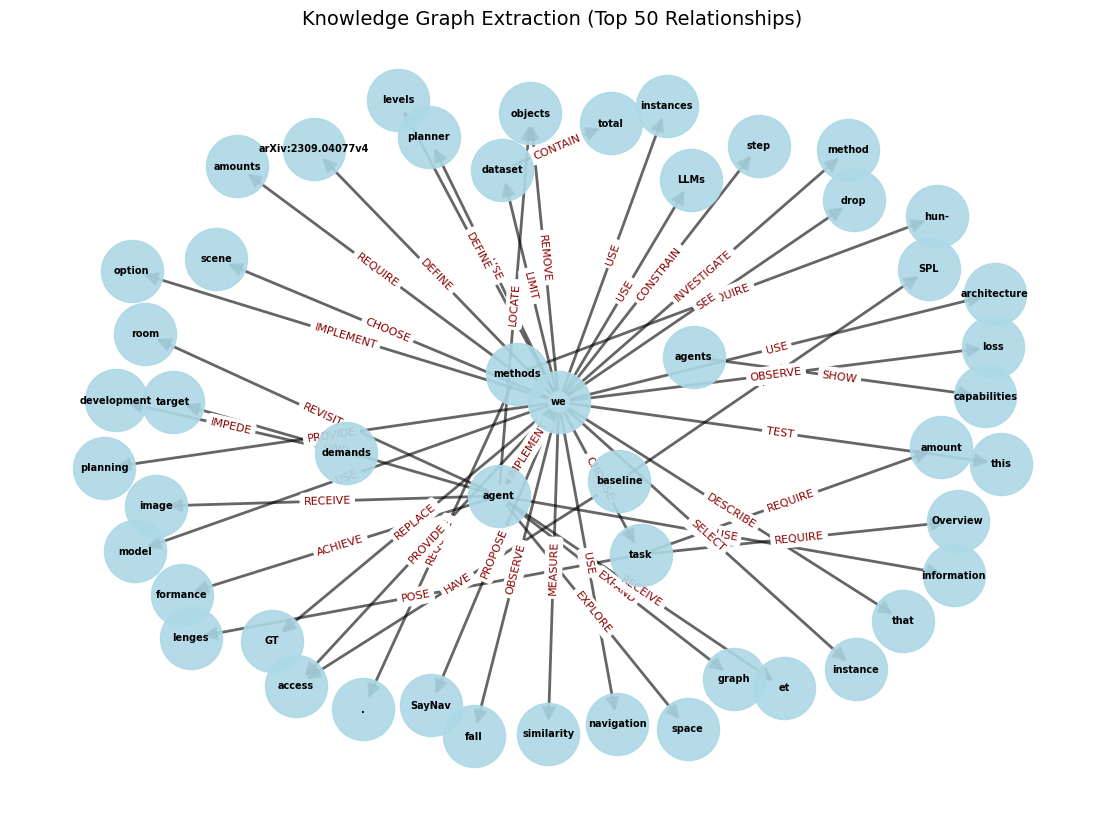

In [7]:
def visualize_knowledge_graph(driver, limit=50):
    """
    Visualizes the Entity-Relationship-Entity graph to show concepts.
    """
    G = nx.DiGraph()

    # Query specifically for Entity relations (Concept -> Action -> Concept)
    query = f"""
    MATCH (n:Entity)-[r]->(m:Entity)
    RETURN n.name AS source, type(r) AS relation, m.name AS target
    LIMIT {limit}
    """

    with driver.session() as session:
        results = session.run(query)
        data = list(results)

    if not data:
        print("No Entity relationships found. Check extraction logic.")
        return

    # Build NetworkX graph
    for record in data:
        source = record['source']
        target = record['target']
        relation = record['relation']
        G.add_edge(source, target, label=relation)

    # Visualization Settings
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.9)
    # Edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, arrowstyle='-|>', arrowsize=20)
    # Labels
    nx.draw_networkx_labels(G, pos, font_size=7, font_family='sans-serif', font_weight='bold')
    # Edge Labels (Actions)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='darkred')

    plt.title(f"Knowledge Graph Extraction (Top {limit} Relationships)", fontsize=14)
    plt.axis('off')
    plt.show()

# Run Visualization
visualize_knowledge_graph(driver)

# 7. Retrieval Module
The search engine of our RAG pipeline.
* **Query Embedding:** Converts the user's question into a vector.
* **Vector Search:** Queries the Neo4j `chunkVectorIndex` to find the 15 most similar text chunks.
* **Context Window:** We retrieve a larger number of chunks (k=15) because Gemini 2.0 has a large context window, allowing us to be more comprehensive.


In [8]:
def retrieve_context(query, k=15):
    """Retrieves top-k relevant chunks using Vector Search."""
    q_emb = embedder.encode(query).tolist()

    with driver.session() as session:
        res = session.run("""
            CALL db.index.vector.queryNodes('chunkVectorIndex', $k, $emb)
            YIELD node, score
            RETURN node.text as text, score
        """, k=k, emb=q_emb)
        records = list(res)

    if not records: return [], 0.0
    text_list = [r['text'] for r in records]
    return text_list, records[0]['score']

# 8. Generation Module (Gemini)
Synthesizes the final answer using the retrieved context.
* **Prompt Engineering:** Uses a strict system prompt to control the AI's behavior.
* **Negative Constraints:** Forces the model to say "NO_EVIDENCE_FOUND" if the answer isn't in the text.
* **Citation Requirement:** Instructs the model to be verbose and explain its reasoning, which aids the verification step later.



In [9]:
def generate_answer(query, context_list):
    """
    Generates an answer based ONLY on the retrieved context.
    Enforces verbose answers to aid verification.
    """
    if not context_list: return "NO_EVIDENCE_FOUND"

    # Join context chunks
    full_context = "\n---\n".join(context_list)

    prompt = f"""You are a research assistant.
    Answer the question based ONLY on the provided context.

    Requirements:
    1. Your answer must be detailed (at least one full sentence).
    2. Do NOT provide one-word answers like "Yes" or "No". Explain WHY based on the text.
    3. If the answer is not in the context, say exactly 'NO_EVIDENCE_FOUND'.

    Context:
    {full_context[:20000]} # Truncate to fit context window

    Question: {query}
    Answer:"""

    try:
        return gemini_model.generate_content(prompt).text.strip()
    except Exception as e:
        return f"Error generating answer: {e}"

# 9. Verification Module (The Sleuth)
The core logic for checking facts. It uses two layers of verification:

1.  **Vector-Based Semantic Check:** We measure "Semantic Similarity" using **Vector Embeddings**.
    * *How:* We convert the text into numbers (vectors) and calculate their cosine similarity.
    * *Why:* This determines if the *meaning* of the answer matches the evidence, even if the exact words are different.
2.  **Hard Entity Veto:** We use SpaCy to extract **Proper Nouns** and **Numbers**.
    * *Why:* If the answer contains a specific name or number that is NOT in the source text, we penalize the score immediately. This catches "confident lies" that might otherwise sound semantically similar.

In [10]:
def verify_answer(question, answer, context_list):
    """
    Returns: Score (float), Reason (str)
    Logic: Boosted Vector Similarity + Hard Entity Veto
    """
    # 1. Handle Refusals
    if "NO_EVIDENCE" in answer or "I cannot answer" in answer:
        return 0.1, "Model Refusal"

    # 2. Vector Similarity (Best Match Strategy)
    ans_vec = embedder.encode(answer)
    best_sem_score = 0.0

    # Check against ALL chunks, find the single best matching sentence/chunk
    for chunk in context_list:
        ctx_vec = embedder.encode(chunk)
        # Cosine similarity
        score = np.dot(ans_vec, ctx_vec) / (np.linalg.norm(ans_vec) * np.linalg.norm(ctx_vec))
        if score > best_sem_score:
            best_sem_score = score

    # CALIBRATION: Boost low raw scores to utilize the full 0-1 range
    boosted_vec_score = (best_sem_score - 0.2) / 0.6
    boosted_vec_score = max(0.0, min(1.0, boosted_vec_score))

    # 3. The "Hard Veto" Check (Entity Verification)
    doc_ans = nlp(answer)

    # Identify Critical Terms (Names, Numbers) vs Generic Nouns
    critical_terms = [t.text.lower() for t in doc_ans if t.pos_ in ["PROPN", "NUM"]]
    generic_terms = [t.lemma_.lower() for t in doc_ans if t.pos_ in ["NOUN"] and t.text.lower() not in critical_terms]

    full_source = " ".join(context_list).lower()

    # Veto Logic
    missing_critical = [t for t in critical_terms if t not in full_source]

    if missing_critical:
        # HARD PENALTY: Hallucinated Entity/Number detected
        final_score = 0.25
        reason = f"Hallucination Detected: The terms {missing_critical} are not in the source text."
    else:
        # Check overlap of generic nouns
        missing_generic = [t for t in generic_terms if t not in full_source]
        if not generic_terms:
            overlap_ratio = 1.0
        else:
            overlap_ratio = 1.0 - (len(missing_generic) / len(generic_terms))

        # Weighted Average Formula
        final_score = (boosted_vec_score * 0.4) + (overlap_ratio * 0.6)
        reason = f"Vector: {best_sem_score:.2f} | Match: {overlap_ratio:.2f}"

    return float(final_score), reason

# 10. Backend Test Suite
Performs a sanity check on the pipeline before running full benchmarks.
* **Manual Queries:** Runs 3 specific questions known to test different capabilities.
* **Tests Structure:** Checks if the system can list components correctly.
* **Tests Refusal:** Checks if the system correctly says "NO_EVIDENCE" for a fake question.
* **Tests Stats:** Checks if the system can verify numerical data.


In [18]:
def test_pipeline(query):
    print(f"\n{query}")
    ctx_list, score = retrieve_context(query)
    if not ctx_list: return

    ans = generate_answer(query, ctx_list)
    print(f"{ans}")

    final_score, reason = verify_answer(query, ans, ctx_list)

    # Preliminary threshold check (0.5)
    tag = "SUPPORTED" if final_score > 0.5 else "FLAGGED"

    print(f"Score: {final_score:.4f} | {tag}")
    print(f"   Details: {reason}")

# Run manual tests
test_pipeline("What are the three modules of the SayNav framework?")
test_pipeline("What specific robot platform (e.g., TurtleBot, Boston Dynamics Spot) was used for the real-world cafeteria demonstration?")
test_pipeline("What is the success rate of SayNav compared to the baseline?")


What are the three modules of the SayNav framework?
The SayNav framework consists of three modules: (1) Incremental Scene Graph Generation, which accumulates observations to build and expand a scene graph encoding semantic entities from explored areas; (2) High-Level LLM-based Dynamic Planner, which continuously converts relevant scene graph information into text prompts for a pre-trained LLM to generate dynamic short-term high-level plans; and (3) Low-Level Planner, which executes each LLM-planned step by generating a series of control commands.
Score: 1.0000 | SUPPORTED
   Details: Vector: 0.83 | Match: 1.00

What specific robot platform (e.g., TurtleBot, Boston Dynamics Spot) was used for the real-world cafeteria demonstration?
NO_EVIDENCE_FOUND
Score: 0.1000 | FLAGGED
   Details: Model Refusal

What is the success rate of SayNav compared to the baseline?
The baseline method achieves a success rate (SR) of 56.06% even when provided with ground-truth object locations in optimal orde

# 11. Threshold Tuning (Calibration)
Scientifically determines the best cutoff score for "Supported" vs "Hallucinated."
* **HaluEval Dataset:** Loads 1,000 samples of real questions with both right and wrong answers.
* **Grid Search:** Tests threshold values from 0.1 to 0.95.
* **Optimization Goal:** Finds the threshold that maximizes the F1-Score (balancing Precision and Recall).
.

In [19]:
def find_optimal_threshold(num_samples=1000):
    """
    Runs a grid search on a calibration subset to find the
    threshold that maximizes F1 Score.
    """
    print(f"Tuning Threshold on {num_samples} calibration samples...")

    # 1. Load Calibration Data
    try:
        # Load dataset and shuffle
        dataset = load_dataset("pminervini/HaluEval", "qa", split="data", trust_remote_code=True)
        samples = dataset.shuffle(seed=42).select(range(num_samples))
    except Exception as e:
        print(f"Dataset Error: {e}")
        return 0.5 # Default fallback

    # 2. Generate Scores
    results = []
    print("Generating calibration scores...")
    for row in tqdm(samples):
        ctx = row['knowledge']

        # Positive Case (Right Answer) - Should pass
        s_pos, _ = verify_answer(row['question'], row['right_answer'], [ctx])
        results.append({'score': s_pos, 'label': 1})

        # Negative Case (Hallucinated Answer) - Should fail
        s_neg, _ = verify_answer(row['question'], row['hallucinated_answer'], [ctx])
        results.append({'score': s_neg, 'label': 0})

    df = pd.DataFrame(results)

    # 3. Grid Search (0.1 to 0.95)
    best_t = 0.5
    best_f1 = 0.0

    for t in np.arange(0.1, 0.95, 0.05):
        y_pred = (df['score'] >= t).astype(int)
        f1 = f1_score(df['label'], y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    print(f"\nOptimal Threshold Found: {best_t:.2f}")
    print(f"(Calibration F1-Score: {best_f1:.2%})")

    return best_t

# Execute and save globally
OPTIMAL_THRESHOLD = find_optimal_threshold(1000)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'pminervini/HaluEval' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'pminervini/HaluEval' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Tuning Threshold on 1000 calibration samples...


README.md: 0.00B [00:00, ?B/s]

qa/data-00000-of-00001.parquet:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating calibration scores...



100%|██████████| 1000/1000 [00:43<00:00, 23.10it/s]



Optimal Threshold Found: 0.55
(Calibration F1-Score: 83.94%)


# 12. Final Quantitative Evaluation
Generates the final performance report for the project.
* **Unseen Data:** Runs the benchmark on a *fresh* set of 1,000 samples (different seed).
* **Metrics:** Calculates Accuracy, Precision, Recall, and F1-Score.
* **Confusion Matrix:** Shows exactly how many True Positives, False Positives, etc., were found.


In [20]:
def run_final_evaluation(threshold, num_samples=1000):
    """
    Runs the final performance test using the fixed threshold.
    """
    print(f"\nRunning Final Evaluation on {num_samples} samples...")
    print(f" Locked Threshold: {threshold:.2f}")

    try:
        dataset = load_dataset("pminervini/HaluEval", "qa", split="data", trust_remote_code=True)
        # Using a DIFFERENT seed (999) to ensure we test on unseen data
        test_samples = dataset.shuffle(seed=999).select(range(num_samples))
    except:
        return

    y_true = []
    y_pred = []

    print("Evaluating...")
    for row in tqdm(test_samples):
        ctx = row['knowledge']

        # 1. Test Faithful Answer (True Positive)
        s1, _ = verify_answer(row['question'], row['right_answer'], [ctx])
        pred1 = 1 if s1 >= threshold else 0
        y_true.append(1)
        y_pred.append(pred1)

        # 2. Test Hallucinated Answer (True Negative)
        s0, _ = verify_answer(row['question'], row['hallucinated_answer'], [ctx])
        pred0 = 1 if s0 >= threshold else 0
        y_true.append(0)
        y_pred.append(pred0)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"\n=== FINAL PERFORMANCE REPORT ===")
    print(f" Threshold Used: {threshold:.2f}")
    print(f"-----------------------------------")
    print(f"Accuracy:  {acc:.1%}")
    print(f"Precision: {prec:.1%}")
    print(f"Recall:    {rec:.1%}")
    print(f"F1-Score:  {f1:.1%}")
    print(f"-----------------------------------")
    print(f"Confusion Matrix:")
    print(f" TP (Correctly Verified):      {tp}")
    print(f" TN (Caught Hallucinations):   {tn}")
    print(f" FP (False Alarm):             {fp}")
    print(f" FN (Missed Valid):            {fn}")

# Run Evaluation
run_final_evaluation(OPTIMAL_THRESHOLD, 1000)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'pminervini/HaluEval' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'pminervini/HaluEval' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.



Running Final Evaluation on 1000 samples...
 Locked Threshold: 0.55
Evaluating...



100%|██████████| 1000/1000 [00:39<00:00, 25.25it/s]


=== FINAL PERFORMANCE REPORT ===
 Threshold Used: 0.55
-----------------------------------
Accuracy:  80.7%
Precision: 72.2%
Recall:    99.7%
F1-Score:  83.7%
-----------------------------------
Confusion Matrix:
 TP (Correctly Verified):      997
 TN (Caught Hallucinations):   616
 FP (False Alarm):             384
 FN (Missed Valid):            3


# 13. Streamlit App Generation
Writes the full Python application code (`app.py`) to disk.
* **Integrated Logic:** Combines ingestion, retrieval, generation, and verification into one file.
* **User Interface:** Creates tabs for "Chat" and "Knowledge Graph."
* **Real-time Feedback:** Displays color-coded verification badges (Green/Red) and allows users to expand details to see *why* an answer was flagged.


In [21]:
%%writefile app.py
import streamlit as st
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
from neo4j import GraphDatabase
import fitz  # PyMuPDF
from langchain_text_splitters import RecursiveCharacterTextSplitter
import spacy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- CONFIG ---
st.set_page_config(page_title="CitationSleuth", layout="wide")

# ==========================================
# PASTE YOUR KEYS HERE
# ==========================================
GOOGLE_API_KEY = "Paste your gemini api key here"
NEO4J_URI = "Paste  your neo4j URI"
NEO4J_PASSWORD = "paste your password here"
# ==========================================

# --- INITIALIZATION ---
if "last_answer" not in st.session_state:
    st.session_state.last_answer = None

if "messages" not in st.session_state:
    st.session_state.messages = []

if GOOGLE_API_KEY and not GOOGLE_API_KEY.startswith("PASTE"):
    genai.configure(api_key=GOOGLE_API_KEY)
    llm = genai.GenerativeModel('gemini-2.5-flash')

@st.cache_resource
def load_resources():
    nlp = spacy.load("en_core_web_sm")
    embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return nlp, embedder

nlp, embedder = load_resources()

def get_db():
    if NEO4J_PASSWORD.startswith("PASTE"): return None
    try: return GraphDatabase.driver(NEO4J_URI, auth=("neo4j", NEO4J_PASSWORD))
    except: return None

# --- 1. GRAPH VISUALIZATION ---
def plot_graph(driver, focus_text=None):
    if not driver: return None, "Database connection failed."

    G = nx.DiGraph()
    title = "Global Knowledge Graph"

    target_names = []
    if focus_text:
        doc = nlp(focus_text)
        target_names = [t.text for t in doc if t.pos_ in ["PROPN", "NOUN"]]
        target_names = list(set(target_names))

    with driver.session() as session:
        if target_names:
            query_specific = """
                MATCH (n:Entity)-[r]->(m:Entity)
                WHERE n.name IN $targets OR m.name IN $targets
                RETURN n.name as source, type(r) as relation, m.name as target LIMIT 50
            """
            res = list(session.run(query_specific, targets=target_names))
            if res:
                title = f"Context Graph ({len(res)} nodes)"
                for r in res: G.add_edge(r['source'], r['target'], label=r['relation'])

        # Fallback to global if empty or no targets
        if G.number_of_nodes() == 0:
            query_global = """
                MATCH (n:Entity)-[r]->(m:Entity)
                RETURN n.name as source, type(r) as relation, m.name as target LIMIT 40
            """
            res = list(session.run(query_global))
            for r in res: G.add_edge(r['source'], r['target'], label=r['relation'])

    if G.number_of_nodes() == 0:
        return None, "Graph is empty. Please ingest a PDF first."

    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.6, seed=42) # Increased k for better spacing

    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='#add8e6', alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.6, arrowstyle='-|>', arrowsize=15, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_family='sans-serif', ax=ax)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='darkred', ax=ax)

    ax.set_title(title, fontsize=16)
    plt.axis('off')
    return fig, "Success"

# --- 2. VERIFICATION LOGIC ---
def verify_answer(answer, context_list):
    """
    Returns: Score (float), UI_Message (str)
    """
    if "NO_EVIDENCE" in answer:
        return 0.01, "The model stated it found no evidence."

    # A. Vector Score
    ans_vec = embedder.encode(answer)
    best_sem_score = 0.0
    best_chunk_idx = 0

    for i, chunk in enumerate(context_list):
        ctx_vec = embedder.encode(chunk)
        score = np.dot(ans_vec, ctx_vec) / (np.linalg.norm(ans_vec) * np.linalg.norm(ctx_vec))
        if score > best_sem_score:
            best_sem_score = score
            best_chunk_idx = i

    boosted = max(0.0, min(1.0, (best_sem_score - 0.2) / 0.6))

    # B. Entity Veto
    doc = nlp(answer)
    keys = [t.lemma_.lower() for t in doc if t.pos_ in ["PROPN", "NUM", "NOUN"]]
    full_src = " ".join(context_list).lower()

    if not keys:
        overlap = 0.5
    else:
        missed = [t for t in keys if t not in full_src]
        overlap = 1.0 - (len(missed) / len(keys))

    # C. Final Score
    if overlap < 0.5:
        final_score = overlap * 0.5
    else:
        final_score = (boosted * 0.4) + (overlap * 0.6)

    # D. Generate UI Message
    if final_score > 0.5:
        chunk_text = context_list[best_chunk_idx]
        return float(final_score), f"**Evidence found in source:**\n\n> {chunk_text}"
    else:
        if keys and missed:
            return float(final_score), f"**Hallucination Suspected:** The answer mentions '{', '.join(missed[:3])}', which was NOT found in the text."
        else:
            return float(final_score), "**Low Confidence:** The answer does not semantically match the provided text."

# --- 3. INGESTION ---
def ingest(file):
    driver = get_db()
    if not driver: return False

    doc = fitz.open(stream=file.read(), filetype="pdf")
    text = "".join([p.get_text() for p in doc])
    chunks = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200).split_text(text)

    with driver.session() as s:
        s.run("MATCH (n) DETACH DELETE n")
        try: s.run("CREATE VECTOR INDEX chunkVectorIndex IF NOT EXISTS FOR (c:Chunk) ON (c.embedding) OPTIONS {indexConfig: { `vector.dimensions`: 384, `vector.similarity_function`: 'cosine' }}")
        except: pass

        bar = st.progress(0)
        for i, c in enumerate(chunks):
            emb = embedder.encode(c).tolist()
            s.run("MERGE (c:Chunk {id:$i}) SET c.text=$t, c.embedding=$e", i=i, t=c, e=emb)

            doc_nlp = nlp(c)
            for token in doc_nlp:
                if token.pos_ == "VERB":
                    sub = [x.text for x in token.children if x.dep_ == "nsubj"]
                    obj = [x.text for x in token.children if x.dep_ == "dobj"]
                    if sub and obj:
                        rel = token.lemma_.upper().replace(" ", "_")
                        if rel.replace("_","").isalnum():
                            s.run(f"MERGE (a:Entity {{name:$s}}) MERGE (b:Entity {{name:$o}}) MERGE (a)-[:{rel}]->(b)", s=sub[0], o=obj[0])
            bar.progress((i+1)/len(chunks))
    return True

# --- 4. RAG PIPELINE ---
def ask(q):
    driver = get_db()
    if not driver: return "DB Error", [], 0.0, "No DB"

    q_vec = embedder.encode(q).tolist()
    with driver.session() as s:
        res = list(s.run("CALL db.index.vector.queryNodes('chunkVectorIndex', 15, $e) YIELD node RETURN node.text as t", e=q_vec))

    if not res: return "No context found in PDF.", [], 0.0, "No context"
    ctxs = [r['t'] for r in res]

    # Prompt ensures long answers
    prompt = f"""You are a research assistant.
    Answer the question based ONLY on the provided context.

    Requirements:
    1. Your answer must be detailed (at least one full sentence).
    2. Do NOT provide one-word answers like "Yes" or "No". Explain WHY based on the text.
    3. If the answer is not in the context, say exactly 'NO_EVIDENCE_FOUND'.

    Context:
    {' '.join(ctxs)[:15000]}

    Question: {q}
    Answer:"""

    try: ans = llm.generate_content(prompt).text.strip()
    except: ans = "Error"

    score, reason = verify_answer(ans, ctxs)
    return ans, ctxs, score, reason

# --- 5. UI LAYOUT ---
st.title("CitationSleuth")
f = st.sidebar.file_uploader("Upload PDF", type="pdf")
if f and st.sidebar.button("Ingest"):
    if ingest(f): st.sidebar.success("Ingested!")

tab1, tab2 = st.tabs(["Chat", "Graph"])

with tab1:
    for m in st.session_state.messages:
        with st.chat_message(m["role"]):
            st.write(m["content"])
            if "score" in m:
                color = "green" if m["score"] > 0.5 else "red"
                st.markdown(f":{color}[**Score: {m['score']:.2f}**]")
                with st.expander("Verification Details"):
                    st.markdown(m["reason"])

    q = st.chat_input("Ask question...")
    if q:
        st.session_state.messages.append({"role":"user", "content":q})
        with st.chat_message("user"): st.write(q)

        a, c, s, r = ask(q)
        st.session_state.last_answer = f"{q} {a}"

        with st.chat_message("assistant"):
            st.write(a)
            color = "green" if s > 0.5 else "red"
            st.markdown(f":{color}[**Score: {s:.2f}**]")
            with st.expander("Verification Details"):
                st.markdown(r)

        st.session_state.messages.append({"role":"assistant", "content":a, "score":s, "reason":r})

with tab2:
    # FIXED: Graph now auto-renders based on state, no refresh button needed
    driver = get_db()
    if driver:
        # Check if we have a question context, otherwise show global
        target = st.session_state.last_answer
        st.caption(f"Visualizing: {'Context of latest Q&A' if target else 'Global Document Structure'}")

        fig, msg = plot_graph(driver, focus_text=target)
        if fig:
            st.pyplot(fig)
        else:
            st.info(msg) # Info is better than error for empty start state
    else:
        st.error("Database not connected.")

Writing app.py


# 14. Launch via Ngrok
Hosts the application and makes it accessible via a public URL.
* **Subprocess:** Starts the Streamlit server in the background.
* **Tunneling:** Uses Ngrok to expose the local Colab port (8501) to the internet.
* **Live Link:** Generates a clickable URL to open the CitationSleuth UI.



In [27]:
from pyngrok import ngrok
import subprocess
import time

ngrok.set_auth_token(NGROK_TOKEN)
ngrok.kill()

# Start Streamlit in the background
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# Give it a moment to start
time.sleep(3)

try:
    # Open the tunnel
    public_url = ngrok.connect(8501).public_url
    print(f"App Live at: {public_url}")
except Exception as e:
    print(f"Error: {e}")

App Live at: https://platinoid-patrick-overproportionately.ngrok-free.dev
